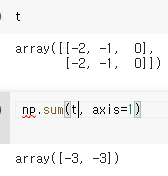

softmax분석 .T써서 만든이유

np.sum하면 [-3,-3]으로 가로로 나오기때문

[-3

-3]으로 나와야함 원래

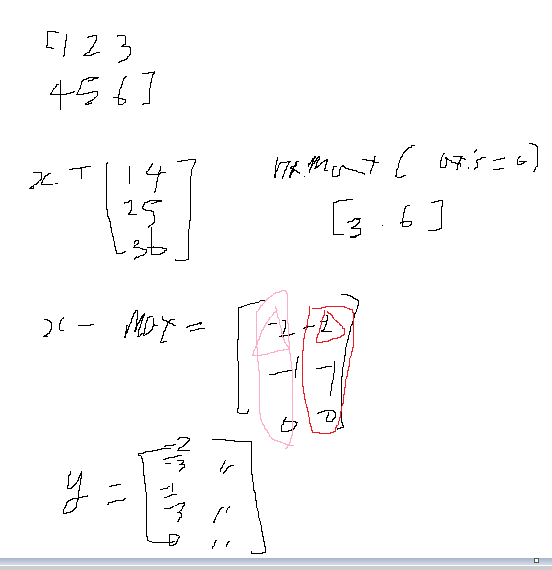

In [1]:
# 실습에 필요한 함수들
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))



def cross_entropy_error(y, t):
    if y.ndim == 1: # 만약 (2,)형태면 (1,2)로 2차원 배열 만들어주기 
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 인코딩이라면 정답 레이블의 인덱스로 반환(return식이 다르기때문에🌞)
    # 훈련정답 t = [100] 
    #              [001] p118보기
    if t.size == y.size: # 원핫인코딩으로 되어있으면
        t = t.argmax(axis=1) # 인덱스 반환!⭐⭐
             
    batch_size = y.shape[0] # 이미지 몇장있었니?
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size # 여기서 t는 [0,2]느낌🌞

def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])

    while not it.finished:
        idx = it.multi_index # (0,0), (0,1), ... 차례대로 순환시작
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        it.iternext()   
        
    return grad

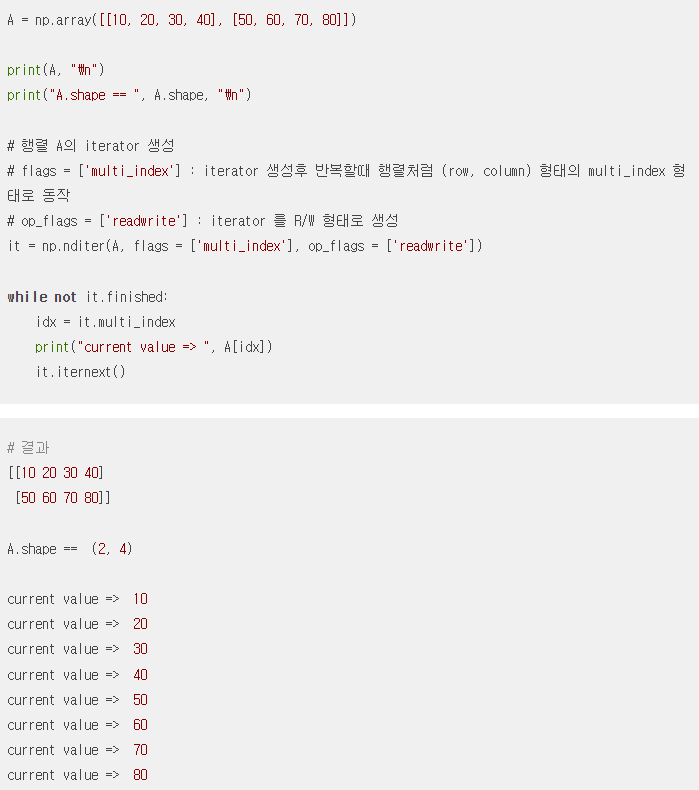

numpy에 있는 nditer() 메서드는 일종에 포인터(화살표)를 만드는 과정이라고 생각하면 되겠습니다. 그 포인터에 it라는 이름을 붙인 것입니다. 그래서 위 코드에서 print(it)를 해보면 그 속에 들어 있는 어떤 실제 값이 아니라 '0x0000012A91F3F850' 와 같은 이상한 값이 출력되지요. 이는 it 포인터가 가리키고 있는 RAM 상의 주소값을 나타냅니다.

multi_index는 다중인덱스를 사용한다는 의미.

nditer() 안에 있는 flags나 op_flags는 포인터 종류를 지정해주는 표시(포인터종류많음)

아마readwrite가 읽고쓰기라 배열의 원소들을 변경해줄수 있다는 뜻 같음

# SimpleNet 신경망 만들기
- 입력2개, 뉴런3개인 신경망
- 편향은 없다고가정

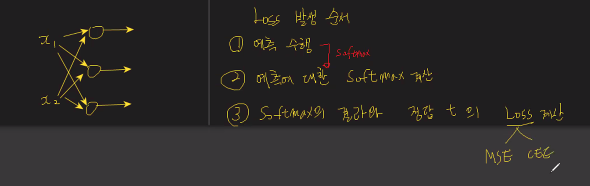

In [2]:
class SimpleNet:

  # 초기화 __init__ 에서는?
  # 신경망이 초기에 가지고 있어야 할 매개변수인 W,b를 셋팅
  # 신경망에서 사용할 레이어 초기화(처음 정의)
  def __init__(self):
    # 1)원시적인 신경망에서는 정규분포 랜덤 * 0.01 > 표준편차가 0.01인 랜덤값을 가중치로 사용
    # 2)카이밍 히 초깃값( He 초깃값 ) - ReLU를 활성화함수로 사용할때 사용하는 초기화 방식
    # 3)사비에르 초깃값( 글로로트 초깃값, Xavier 초깃값) - sigmoid, tanh를 활성화함수로 사용할때 사용하는 초기화 방식
    # 정해진건 없고 효과에 맞게 쓰면됨
    # 1번 정규분포로 해볼거

    np.random.seed(42)
    self.W = np.random.randn(2,3)

  def predict(self, x):
    return x @ self.W


  def loss(self, x, t):
    z = self.predict(x)
    y = softmax(z)

    loss_val = cross_entropy_error(y,t)
    return loss_val



In [4]:
net = SimpleNet()
print("가중치 : \n{}".format(net.W))

가중치 : 
[[ 0.49671415 -0.1382643   0.64768854]
 [ 1.52302986 -0.23415337 -0.23413696]]


In [7]:
x = np.array([0.7, 0.9])
y = net.predict(x)

print("예측값 : \n{}".format(y))

예측값 : 
[ 1.71842678 -0.30752305  0.24265872]


In [8]:
t = np.array([1,0,0]) # 정답 원핫인코딩

t_error = np.array([0,1,0]) # 오답 원핫인코딩

print(net.loss(x,t)) # 정답일때 loss
print(net.loss(x,t_error)) # 오답일때 loss CEE의 장점. 오답오류를 극단적으로 표현해줌!

0.30783127541972677
2.3337802057254837


# loss 함수에는 W가 없음 predict(얘가 W사용) 가 들어있지.

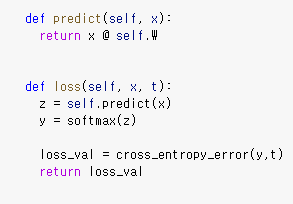

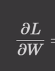

얘의 L(loss)는 w에 대한 '함수' 여야함!
미분전에 loss를 값으로 구해버리면 안됨. 

2.3 마냥 로스 값미리 실행시킨 값을 미분하면 0나옴

In [9]:
# 똑같이 loss값을 구하기 위한 함수인데
# W에 대해 보는거. W가 이거일때 loss가 얼만큼 나올꺼에요
def f(W):
  return net.loss(x,t) # x, t 다 상수

# f = lambda params : self.loss(x,t)

In [10]:
dW = numerical_gradient(f, net.W) # 미분할 때 f가 실행될거임.⭐⭐ callback
# w가 h만큼 약간 변화되었을 때 f가 실행되어야함.
dW

# tmp_val 에는 w들이 들어갈거.

array([[-0.18547252,  0.06784997,  0.11762254],
       [-0.23846466,  0.08723568,  0.15122899]])

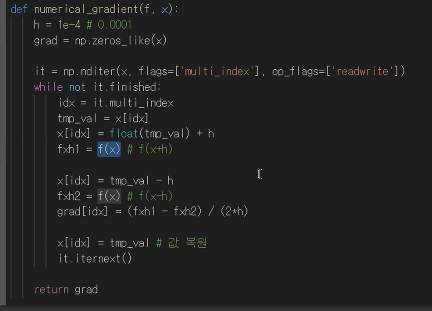

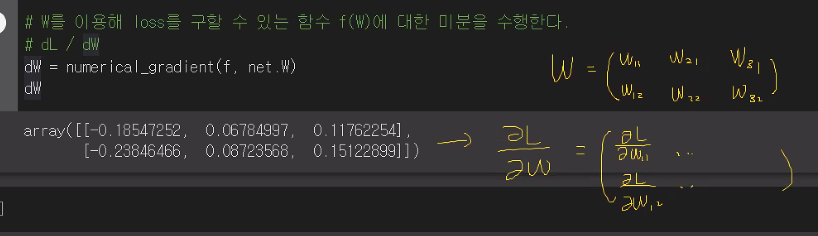

w11이 조금바뀌면 loss가 0.18547252만큼 감소한다

# 학습이 가능한 MNIST 신경망 구현
- 2층 신경망이고
- 1층 은닉층의 뉴런 개수 100개
  - 활성화 함수로 시그모이드

- 2층 출력층의 뉴런개수는 10개
  - 숫자가 0~9까지 이기때문에 10개
  - 활성화 함수로는 다중분류라서 softmax사용

-loss함수는 cross_entropy_error사용

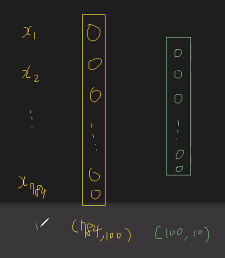

In [12]:
class TwoLayerNet:

  # default파라미터 걸어놓기. 하이퍼파라미터라 인간이 바꿔줘도됨
  def __init__(self, input_size=28 * 28, hidden_size=100, output_size=10, weight_init_std=0.01): # weight_init_std = 정규분포 랜덤값에 표준편차 0.01을 적용하기 위함
    self.params = {} # 층별 모델 파라미터 W,b를 저장할 딕셔너리
    
    # 1층 매개변수 초기화
    self.params["W1"] = weight_init_std * np.random.rand(input_size, hidden_size) # 1층 가중치 = (784,100)
    self.params["b1"] = np.zeros(hidden_size) # 1층의 편향 (100,)


    # 2층 매개변수 초기화
    self.params["W2"] = weight_init_std * np.random.rand(hidden_size, output_size) # 2층 가중치 = (100,10)
    self.params["b2"] = np.zeros(output_size) # 2층의 편향 (10,)


  def predict(self, x):
    # 1층 은닉층은 sigmoid함수
    # 2층 은닉층은 softmax함수

    # 각 층의 가중치, 편향을 params에서 꺼내온다.
    W1, b1 = self.params["W1"], self. params["b1"]
    W2, b2 = self.params["W2"], self. params["b2"]

    # 1층계산
    z1 = x @ W1 + b1
    a1 = sigmoid(z1)

    # 2층계산
    z2 = a1 @ W2 + b2
    y = softmax(z2)

    return y # 예측 끝


  def loss(self,x,t):
    y = self.predict(x)
    loss_val = cross_entropy_error(y, t)
    return loss_val

  # 미분해서 W,b별 기울기 배열 구하기!
  def numerical_gradient_params(self, x, t):

    # 기울기를 저장할 dict
    grads = {}

    # loss바로 미분 불가능.⭐⭐
    f = lambda params : self.loss(x,t) # params에는 W1,W2,b1,b2들어있음

    print("======미분시작======")

    # 1층 매개변수에 대한 기울기 구해서 grads에 저장
    grads["W1"] = numerical_gradient(f, self.params["W1"]) # dL / dW1
    grads['b1'] = numerical_gradient(f, self.params['b1']) # dL / db1
    
    # 2층 매개변수에 대한 기울기 구해서 grads에 저장
    grads["W2"] = numerical_gradient(f, self.params["W2"]) # dL / dW2
    grads['b2'] = numerical_gradient(f, self.params['b2']) # dL / db2

    print("======미분끝======")

    return grads






# MNIST 데이터 불러오기 및 전처리

In [13]:
from tensorflow.keras import datasets
mnist = datasets.mnist

(X_train, t_train), (X_test, t_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], -1) # 데이터의 개수 만큼 입력 특성(특징 벡터)를 만든다.
X_test  = X_test.reshape(X_test.shape[0], -1)

X_train.shape, X_test.shape

11490434/11490434 [==============================] - 0s 0us/step


((60000, 784), (10000, 784))

In [14]:
import tensorflow as tf

t_train_one_hot = tf.one_hot(t_train, 10).numpy()
t_test_one_hot  = tf.one_hot(t_test, 10).numpy()

t_train_one_hot.shape, t_test_one_hot.shape

((60000, 10), (10000, 10))

In [15]:
t_train_one_hot[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

# 이미지 데이터 정규화
- 이미지 데이터는 항상 0~255사이의 정숫값을 기본적으로 갖는다.
- 0 ~ 255사이의 숫자 차이는 매우 크기 때문에 0~1로 정규화

In [ ]:
# min_max_scale안써도됨. 항상 0~255값 고정이기 때문에!
X_train = X_train / 255.0
X_test = X_test / 255.0 

# 모델 훈련 준비 - 하이퍼 파라미터 설정
- 미니 배치 개수
- (미니배치 당)훈련 반복 횟수
- 학습률

60000장 미니배치사이즈 600짜리로
⭐100번 돌았다. 완주! = 1에폭⭐

*훈련 세트에 대해⭐
- 에폭 증가 > 훈련 세트에 대한 정확도 증가, loss감소 (문제집 n회독느낌)
- 에폭을 너무늘려도 안댐. 과대적합위험

In [ ]:
# 미니배치 개수 보통 32, 64개가 적당하다고 알려져있음(논문결과) 우리는 100개쓸꺼 ㅋㅅㅋ

train_size = X_train.shape[0] # 60000
batch_size = 100

# 반복횟수
iter_nums = 10000

# 학습률(미분값 얼마나 반영할건지)
learning_rate = 0.1


# 모델 훈련

In [17]:
from tqdm import tqdm_notebook

# tqdm : 반복 진행 상황을 progress bar로 시각적으로 보여주기 위한 패키지

for i in tqdm_notebook(range(iter_nums)):
  pass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
net = TwoLayerNet()

for i in tqdm_notebook(range(iter_nums)):

  # 1. 미니배치 인덱스 선정(마스크 만들기)
  batch_mask = np.random.choice(train_size, batch_size) # 0~59999 중 100개를 임의로 선택 책 117페이지 60000미만

  # 2. 미니 배치 생성
  X_batch = X_train[batch_mask] # (100, 784)
  t_batch = t_train_one_hot[batch_mask] # (100,10)

  # 3. 각 매개변수의 기울기 배열 구하기(미분수행)
  # 미분 수행의 결과를 이용해서 실제 좌표를 경사하강법으로 갱신

  grads = net.numerical_gradient_params(X_batch, t_batch) # 예측, loss, 미분 한번에

  # params와 grads가 같은 키값을 가지고 있다.
  keys = ["W1", "b1", "W2", "b2"]

  # 경사하강법 수행
  for key in keys:
    net.params[key] = net.parmas[key] - (learning_rate * grads[key])

  # 경사하강법 수행후 loss확인
  loss = net.loss(X_batch, t_batch)
  print("갱신된 Loss : Step {} --> Loss : {:.3f}".format((i+1),loss))


params에 있는걸 갱신한다

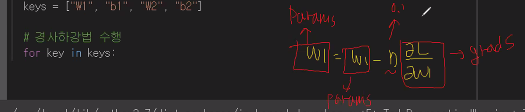

# 위에꺼 보름걸림 줠라오래걸림 이렇게 느려서 어케써먹겠냐

오차역전파 발견

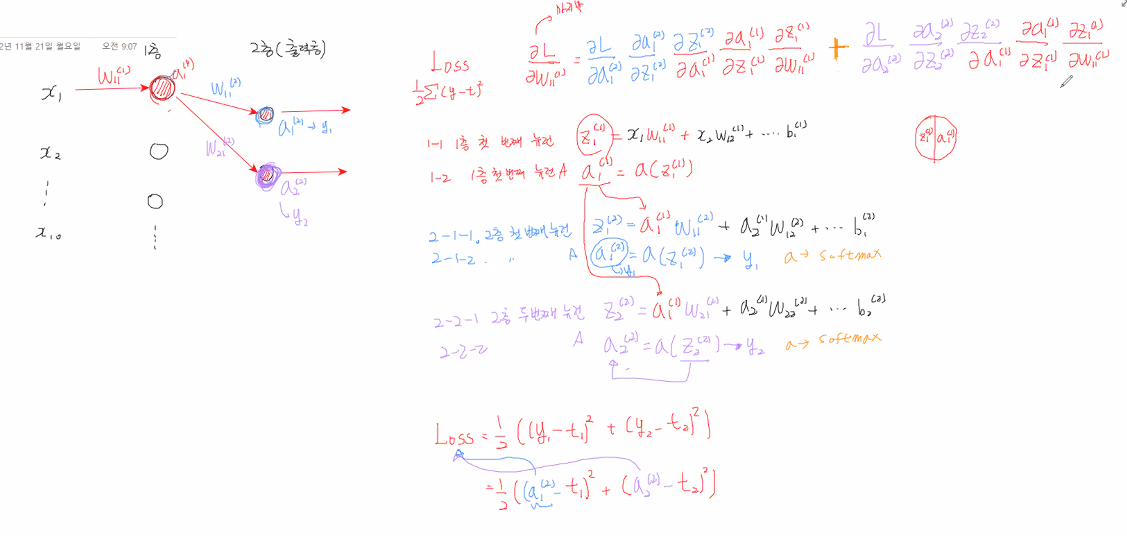

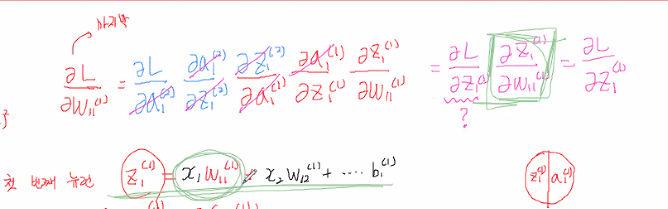

델타* x1만 남음
우리목표: 델타 =  dz1 / dW11(1) 만 구하면됨!!